# Final Visualization Project
## Data Handling and Visualization
### MSc Data Science (with Placement Year)
#### University of Hertfordshire
**Author:** Cristina Baron Suarez  
**Student ID:** 23069038

I collaborate with a research team at the University of Malaga. This group has been following older adults annually using accelerometry. They use accelerometers for approximately ten days, and it is during this time that the activities of the patients are measured. The group wants to identify patterns that extend beyond this period, but the number of accelerometers is limited. Therefore, several patients share the same device.

The main goal of this project is to know whether it is possible to detect signals of different frequencies in the combined accelerometry data for the observed period, even if the patients have been swapping accelerometers among themselves.

The study has data from 2014 to 2024. However, in 2015 there was a lack of funding, so data was collected only for a few months, and in 2020 COVID emerged and altered data collection. Therefore, we will limit our analysis to the accelerometry data collected between both periods.

In [234]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [235]:
df0 = pd.read_csv('Sleep-Walking.csv')
df0.head()

code  followUpYear                                  file        date  \
0  P201001           2.0  01001_02__017698_2016-11-29_13-25-12  2016-11-22   
1  P201001           2.0  01001_02__017698_2016-11-29_13-25-12  2016-11-23   
2  P201001           2.0  01001_02__017698_2016-11-29_13-25-12  2016-11-24   
3  P201001           2.0  01001_02__017698_2016-11-29_13-25-12  2016-11-25   
4  P201001           2.0  01001_02__017698_2016-11-29_13-25-12  2016-11-26   

   bedTimeStarts  bedTimeMiddle  bedTimeEnds  bedDuration  bedSIBDuration  \
0          -1.20           3.60         8.40         9.60            6.40   
1           0.63           4.01         7.38         6.75            4.13   
2           0.08           3.91         7.73         7.65            4.83   
3          -1.00           3.21         7.42         8.42            4.67   
4          -0.07           4.60         9.27         9.33            5.25   

   dur_walking  ENMO_walking  steps_walking  
0        175.0         62.86         8647.2  
1        217.0         58.26         9540.0  
2        317.0        111.95        22403.0  
3        253.0         90.47        15567.0  
4        189.0         62.95         6995.0

For each patient, we have several fields:
- “code”: identifies the patient
- “date”: indicates the day the measures were taken
- Set of variables automatically calculated from the day’s summary, such as the time they got out of bed, steps taken,...

Let us set the variable 'bedTimeEnds' as a unique value for each day of the studied period. For that, we are going to use the mean collected from all the accelerometers that were active during the selected period of time. As the patients are different, and each of them can have a specific hour of waking up, that is going to introduce significant variability. To reduce it, we will consider how far each individual **deviates** from their own personal mean by subtracting the average observed over the entire study in each participant from the value observed on a specific day. This will be saved in the new column `deviation`.

In [251]:
# Get the mean time each person wakes up
dfMean = df0.groupby('code', as_index = False)['bedTimeEnds'].mean()
dfMean.rename(columns = {'bedTimeEnds': 'bedTimeEndsMean'}, inplace = True)

# "deviation" is the difference between the time a person wakes up and their mean awaken time
# We do not care about the time the person wakes up, but the difference with the mean
df = pd.merge(df0, dfMean, on = 'code', how = 'inner').assign(deviation = lambda x: x['bedTimeEnds'] - x['bedTimeEndsMean'])[['date', 'bedTimeEnds', 'deviation']].groupby('date', as_index = False).mean()
df.head()

date  bedTimeEnds  deviation
0  2016-03-15     9.090000   0.114759
1  2016-03-16     8.689333  -0.051349
2  2016-03-17     8.303913  -0.354033
3  2016-03-18     8.595217  -0.062729
4  2016-03-19     8.694545   0.161345

Therefore, our dataset contains daily records over a four-year period with the following variables:

- **Date**: The date of the observation.
- **bedTimeEnds**: Mean time the subject having an accelerometer woke up.
- **deviation**: Mean deviation from the time each one of them usually wake up.

## Fourier transform of the deviation of mean awakening times

In [237]:
varInterest = 'deviation'
numFrequencies = 9

In [238]:
def scrfft(xdata, ydata):
    sdata = np.argsort(xdata) # Indices that would sort xdata
    xdatas = xdata[sdata] # Sort xdata
    ydatas = ydata[sdata] # Sort ydata

    # Find the minimum and maximum of 'xdata' and the number of data points
    xmin = np.min(xdata)
    xmax = np.max(xdata)
    ndata = len(xdata)

    # Create an evenly spaced array between xmin and xmax
    x = (xmax - xmin) / (ndata - 1) * np.arange(ndata) + xmin

    # Interpolate the sorted data onto the array
    y = np.interp(x, xdatas, ydatas)

    # Compute the Fourier transform 
    yf = 2.0 * np.fft.rfft(y) / (ndata + 1)

    # Extract real and imaginary parts from the Fourier coefficients
    a = np.real(yf)
    b = -np.imag(yf) # Take the negative imaginary part

    # Set the DC component to half its value
    a[0] = 0.5 * a[0]

    # Calculate the frequency array
    f = np.arange(len(a)) / (xmax - xmin)
    
    return(f, a, b)

In [239]:
# Convert the "Date" column to a numerical format
df['date'] = pd.to_datetime(df['date'])

# We calculate the time based on the number of the row because of August
df['Time'] = df.index

# Extract the "Time" column as an array
stime = df['Time'].values   # X-axis

# Extract the values of 'varInterest'
snum = df[varInterest].values  # Y-axis
ndata = len(snum) # Get the number of data points in 'snum'

# Perform the FFT
freqs, ccoef, scoef = scrfft(stime, snum)

# Calculate the power spectrum
power = ccoef**2 + scoef**2

# Calculate the periods
periods = 1 / freqs

# Find the indices of the top 'numFrequencies' most significant frequencies
interestingIdxs = np.argsort(power)[::-1][:numFrequencies]

print('Most important frequencies:', freqs[interestingIdxs].round(2))
print('Most important periods:', periods[interestingIdxs].round(1))
print('Most important powers:', power[interestingIdxs].round(1))

Most important frequencies: [0.   0.14 0.15 0.28 0.14 0.14 0.14 0.15 0.15]
Most important periods: [319.8   7.1   6.8   3.5   7.    7.1   7.3   6.7   6.8]
Most important powers: [0. 0. 0. 0. 0. 0. 0. 0. 0.]


/tmp/ipykernel_864983/1576875818.py:21: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / freqs


## Power spectrum of daily awakening time deviations

We are now going to calculate the power spectrum showing contribution of different periods (from one week to one year) in the daily variation in awakening, and we plot this power spectrum as a vertical line plot.

Let's create a plot showing frequency againts power.

In [240]:
def plotXvsY(x, y, xlabel, ylabel):
    """
    Plot 'x' againt 'y'
    """
    plt.figure(dpi = 144)

    plt.plot(x, y)
    
    plt.xlabel(xlabel, fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.ylabel(ylabel, fontsize = 14)
    plt.yticks(fontsize = 14)
    
    plt.show()
    return

In [241]:
fourier = np.zeros(ndata)

# Sum the cosine and sine terms of the frequencies
for i in interestingIdxs:
    fourier += ccoef[i] * np.cos(6.2832 * freqs[i] * stime) + scoef[i] * np.sin(6.2832 * freqs[i] * stime)
df['fourier'] = fourier

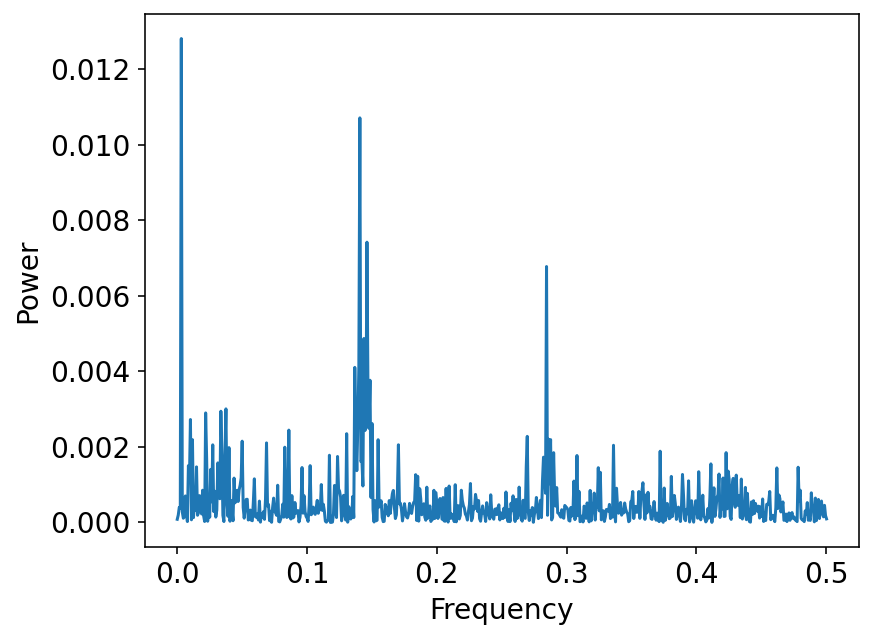

In [242]:
plotXvsY(freqs, power, 'Frequency', 'Power')

Let's create a bar plot showing period against power, since I find periods easier to understand than frequencies.

In [252]:
def vLinePlot(x, y, xlabel, ylabel):
    """
    Plot a bar chart using the 'x' and 'y' variables
    """
    plt.figure(dpi = 144)
    
    plt.vlines(x, [0]*len(x), y, color = 'blue', linewidth = 2)
    
    plt.xlabel(xlabel, fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.ylabel(ylabel, fontsize = 14)
    plt.xticks(fontsize = 14)

    plt.xscale('log')
    xticks = [1, 7, 334, 1000]
    plt.xticks(xticks, labels = [str(tick) for tick in xticks], fontsize = 14)
    
    plt.show()
    return

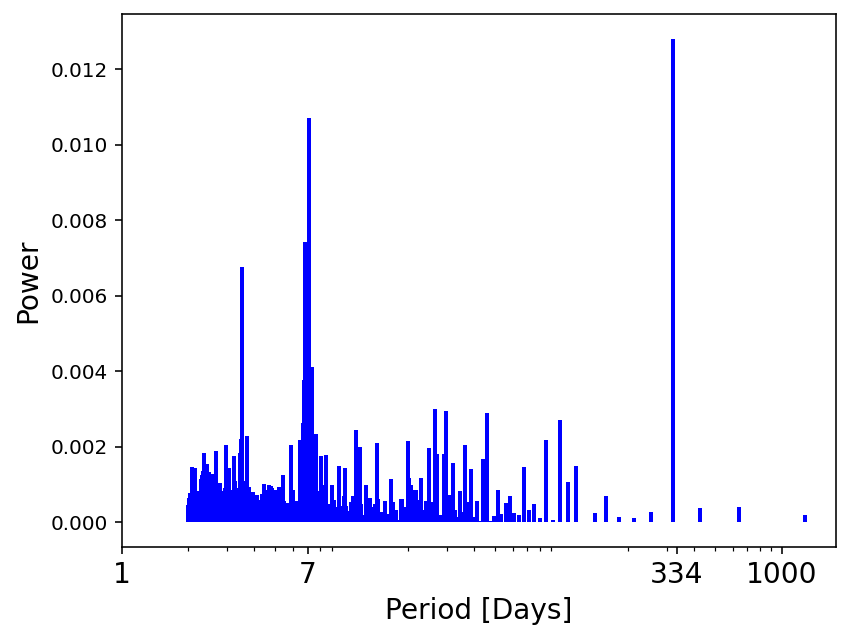

In [244]:
# Let's show the periods in a days format
vLinePlot(periods, power, 'Period [Days]', 'Power')

It seems that the `deviation` is related to periodic components of 320 days (**we have removed 31 days from august**- since no data is collected during this month-, so almost a year) and 7 days. The reason why the longest period can be observed over the course of the year could be probably explained by the time of sunrise. Furthermore, the seven-day cycle is related to the fact that people tend to wake up differently on weekends compared to Monday through Friday.

Having identified the most significant frequencies, and they seem to make sense. Let's visualize how the selected frequencies model the deviations.

In [245]:
# Plot with the observed real data and the predicted data
def plotRegressionFourier(time, num, predicted, xlabel, ylabel):
    plt.figure(figsize = (10, 5), dpi = 144)

    # Plot the real data
    plt.plot(df[time], df[num], label = 'Real', alpha = 0.75, linewidth = 0.25)

    # Plot the predicted data
    plt.plot(df[time], df[predicted], label = 'Predicted', alpha = 0.75, linewidth = 0.55)
    
    plt.xlabel(xlabel, fontsize = 14)
    plt.xticks(fontsize = 14, rotation = 90)
    plt.ylabel(ylabel, fontsize = 14)
    plt.yticks(fontsize = 14)

    plt.legend()
    plt.show()
    return

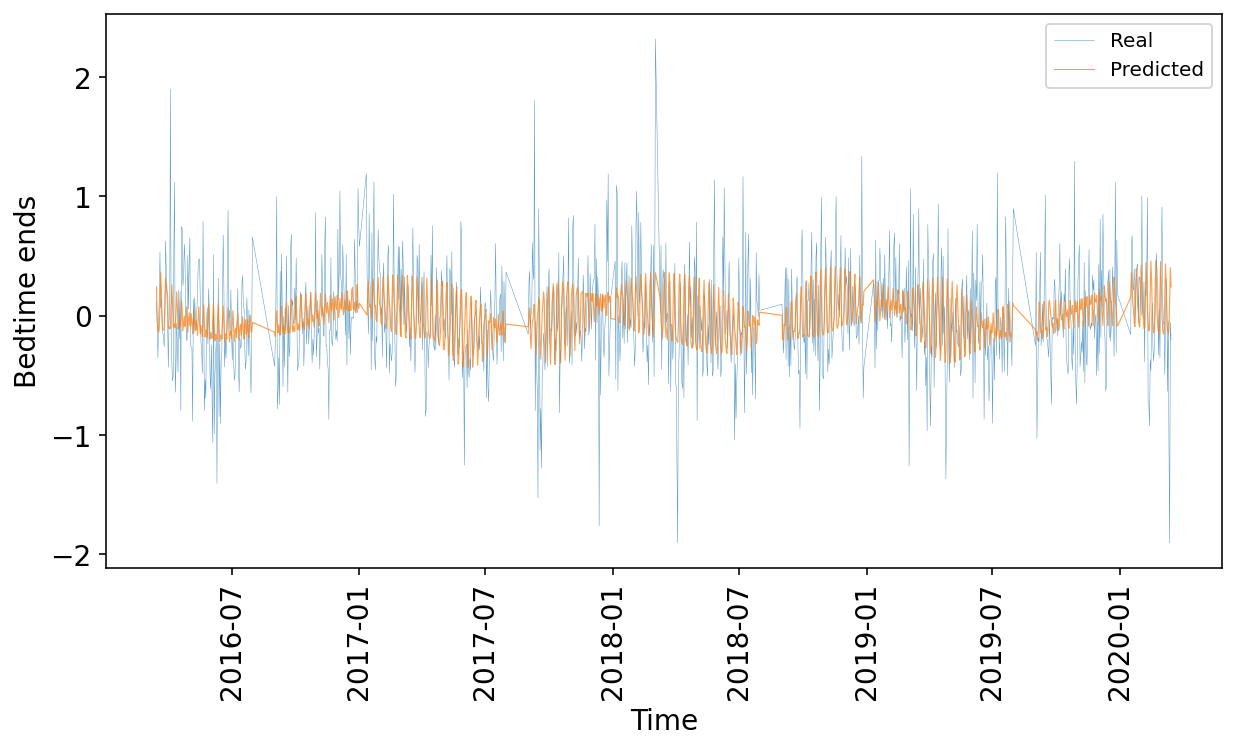

In [246]:
plotRegressionFourier('date', 'deviation', 'fourier', 'Time', 'Bedtime ends')

From the previous plot we can appreciate the yearly and weekly patterns in the dataset, but of course we have only chosen those first most important frequencies. There is of course more variability in the data than just that!

## Monthly distribution of mean deviations in awakening time

Let us show the average outcome for each month, except for August, since no data has been collected in this month.

In [253]:
def predictedModel(time, num, ticklabel, predicted, ylabel, title):
    # Average of actual data grouped by time
    avgPredict = df.groupby(time)[num].mean()

    # Average of predicted data grouped by time
    avgFourier = df.groupby(time)[predicted].mean()
    
    # Plot histogram and fourier series approximation
    x_positions = range(len(ticklabel))
    plt.figure(figsize = (10, 5), dpi = 144)
    plt.bar(x_positions, avgPredict, tick_label = ticklabel, label = ylabel)
    plt.plot(x_positions, avgFourier, color = 'red', marker = 'o', linestyle = '-', linewidth = 2, label = 'Fourier Series Approximation')
    
    plt.xlabel(time, fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.ylabel(ylabel, fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.title(title, fontsize = 16)
    
    plt.legend()
    plt.show()
    return

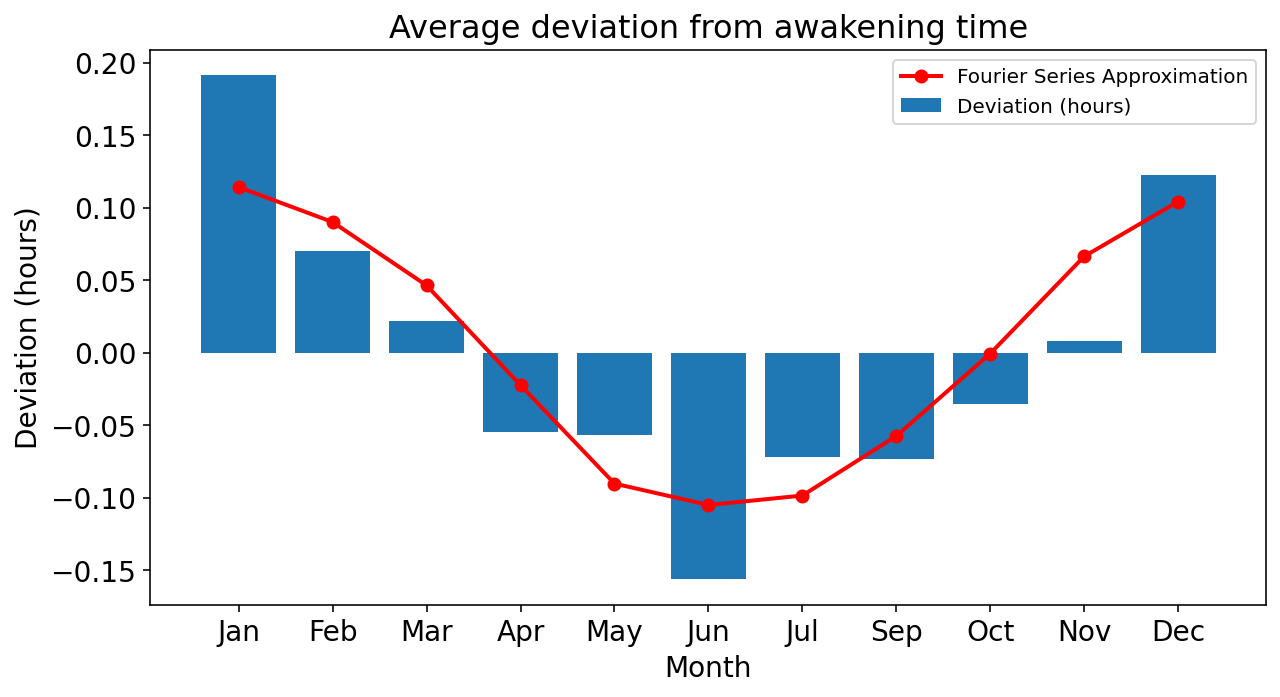

In [248]:
df['Month'] = df['date'].dt.month
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Sep', 'Oct', 'Nov', 'Dec']

predictedModel('Month', 'deviation', months, 'fourier', 'Deviation (hours)','Average deviation from awakening time' )

Apparently, the deviations in awakening time are related to the changes in daylight throughout the year, although in June the elderly wake up much earlier than we would expect by the data seen in neighboring months and the Fourier model. This may be explained because in Spain the school timetables change, but not the parents’ working schedules, and it is a month in which many families need the help of grandparents to take the children to school.

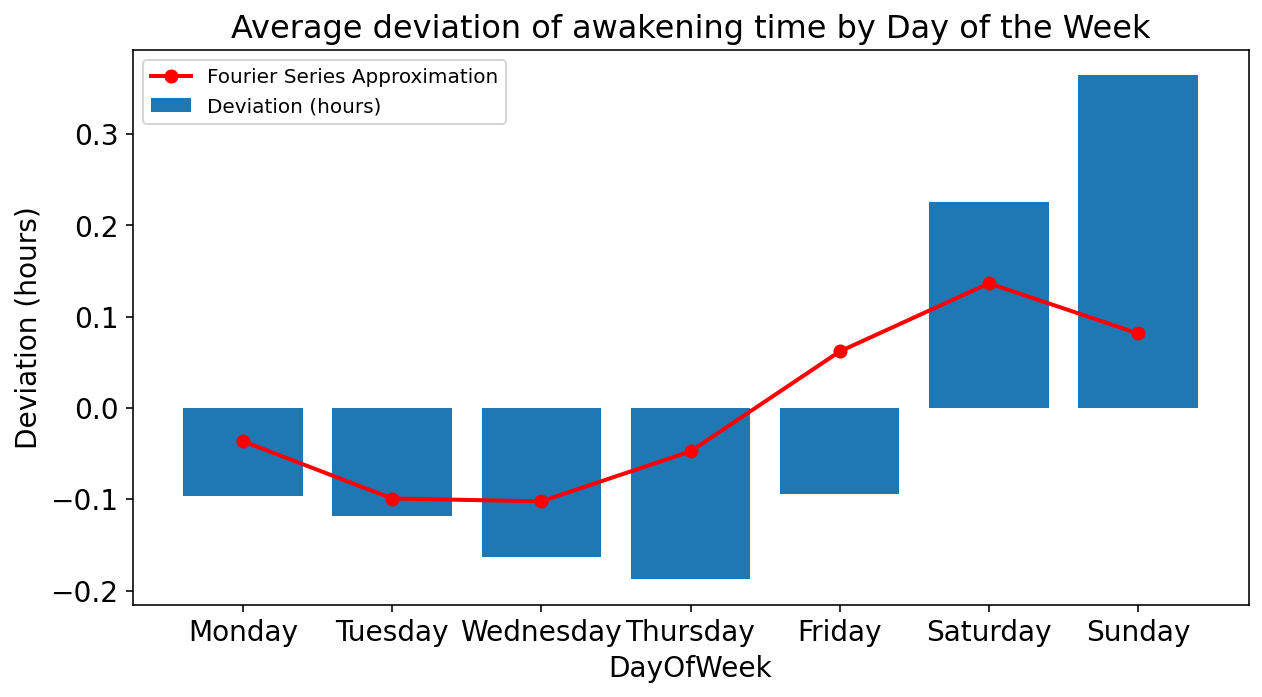

In [249]:
df['DayOfWeek'] = df['date'].dt.dayofweek
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

predictedModel('DayOfWeek', 'deviation', days, 'fourier', 'Deviation (hours)', 'Average deviation of awakening time by Day of the Week')

The observed weekly pattern is expected: People wake up later on weekends.

On the other hand, the Fourier approximation struggles to estimate properly the transition to weekends, as is too abrupt to be discerned with the limited number of frequencies that we have chosen.